In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os


In [12]:
material_path=r"E:\ZhixiYun\Projects\Neuron_Morphology_Table\Materials"
df_all_tmp = pd.read_csv(os.path.join(material_path, "projection_matrix/AutoArbor/", "All_Arbor_Projection.csv"),index_col=0)
df_soma_tmp = pd.read_csv(os.path.join(material_path, "projection_matrix/AutoArbor/", "Dendritic_Arbor_Projection.csv"),index_col=0)


newcols = [x.replace("ipsi_","") for x in list(df_all_tmp.columns)[0:int(len(df_all_tmp.columns)/2)]]
df_all = pd.DataFrame(df_all_tmp.values[:,0:len(newcols)]+df_all_tmp.values[:,len(newcols):], index=df_all_tmp.index, columns=newcols)
df_soma = pd.DataFrame(df_soma_tmp.values[:,0:len(newcols)]+df_soma_tmp.values[:,len(newcols):], index=df_soma_tmp.index, columns=newcols)

df_ct = pd.concat([pd.read_csv(os.path.join(material_path,"cell_type/s_type","AIBS+SEU-ALLEN_Full_1741.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","MouseLight_Full_1200.csv"), index_col=0), 
                   # pd.read_csv(os.path.join(material_path,"cell_type/s_type","ION_Axon_6357.csv"), index_col=0)
                  ])
newindex = []
for ind in df_ct.index:
    if ind.find("auto")!=-1 or ind.find("semi")!=-1:
        newindex.append(ind.split('.')[0]+'.swc')
    else:
        newindex.append(ind)
df_ct.index = newindex

with open(r"./config/tree.json") as f:
    tree = json.load(f)
    
lutnametoid = dict(zip([t["acronym"] for t in tree], [t["id"] for t in tree]))
lutidtoname = dict(zip([t["id"] for t in tree], [t["acronym"] for t in tree]))
roughlist = ['Isocortex', 'OLF', 'HPF', 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CBX', 'CBN']
lutnametorough = {}
for t in tree:
    lutnametorough[t['acronym']] = t['acronym']
    for rough in roughlist:
        if lutnametoid.get(rough) in t['structure_id_path']:
            lutnametorough[t['acronym']] = rough
            break

In [13]:
def sort_region(ctlist):
    sort_list = []
    for t in tree:
        name = t['acronym']
        if name in ctlist:
            sort_list.append(name)
    return sort_list


In [14]:
'''select celltype which number is over 10 '''

used_ct = list(df_ct['CellType'].value_counts()[df_ct['CellType'].value_counts()>10].index)
used_ct.remove("MB")
used_ct.remove("HY")
for ct in used_ct:
    for t in tree:
        if t["acronym"] == ct:
            if 1009 in t["structure_id_path"]:
                print('removed fiber tracts region:', ct)
                used_ct.remove(ct)
used_ct = sort_region(used_ct)
len(used_ct)

removed fiber tracts region: dhc


44

In [15]:
'''generate celltype-indexed dataframe which shows average projection length '''
df_all_mean = pd.DataFrame(columns=df_all.columns)
for ct in used_ct:
    series = df_all.loc[df_ct[df_ct.CellType==ct].index].mean()
    df_all_mean.loc[ct] = series
df_soma_mean = pd.DataFrame(columns=df_soma.columns)
for ct in used_ct:
    series = df_soma.loc[df_ct[df_ct.CellType==ct].index].mean()
    df_soma_mean.loc[ct] = series
    

In [16]:
used_proj_region = list(df_all_mean.max()[df_all_mean.max()>2000].index)
used_proj_region = sort_region(used_proj_region)
used_proj_region.remove("fiber tracts")
print("used projection region number: ",len(used_proj_region))
# print("intersection shape:", np.intersect1d(np.array(yticks),np.array(list(df_all_mean.max()[df_all_mean.max()>2000].index))).shape)


used projection region number:  75


In [17]:
df_plot = pd.DataFrame(columns=['x','y','Celltype','Mean','Ratio'])
region_number = len(used_proj_region)
for i in range(len(used_ct)):
    ct = used_ct[i]
    for j in range(len(used_proj_region)):
        proj_region = used_proj_region[j]
        mean_ = df_all_mean.loc[ct,proj_region]
        ratio_ = (mean_-df_soma_mean.loc[ct,proj_region])/(mean_+1e-20)
        df_plot.loc[i*region_number+j] = [i,j,ct,mean_,ratio_]

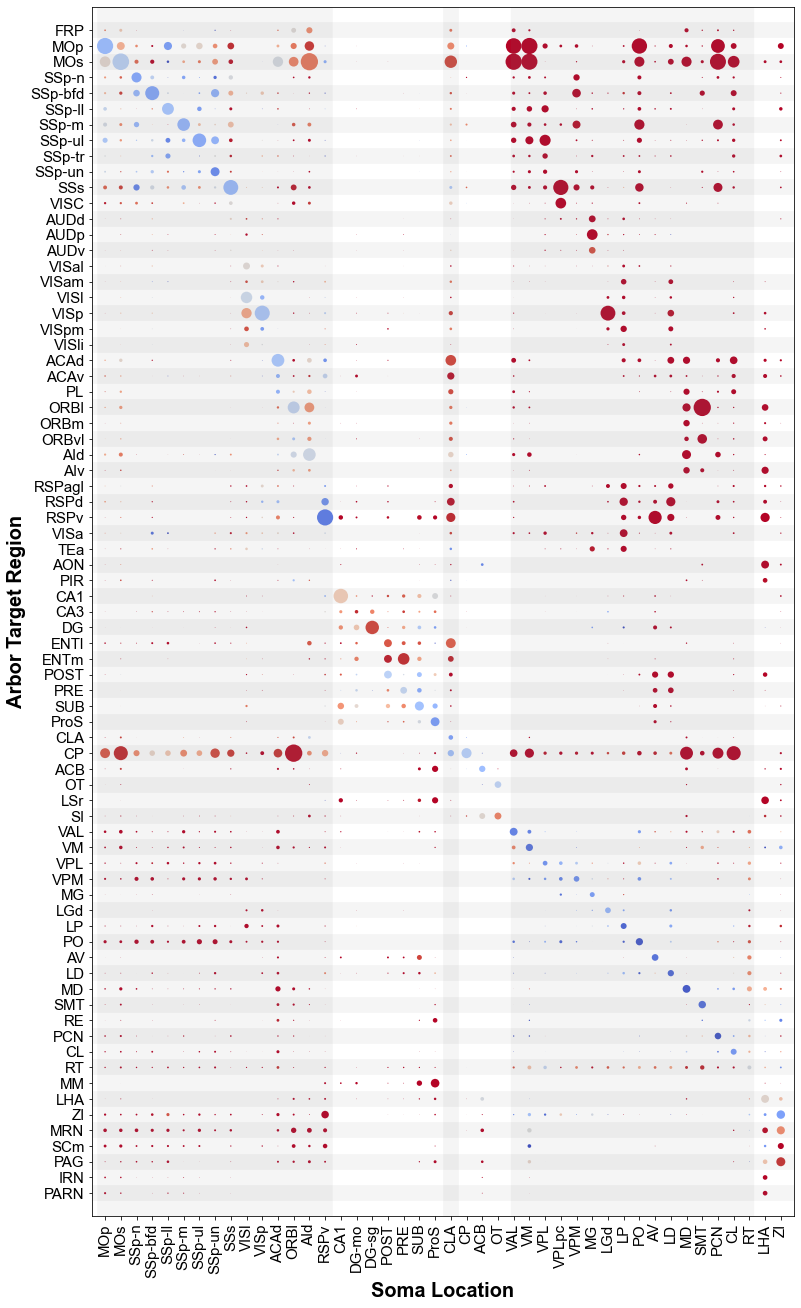

In [18]:
xticks = used_ct
yticks = used_proj_region

g = sns.relplot(
    data=df_plot,
    x="x", y="y", hue="Ratio", size="Mean",
    palette="coolwarm", edgecolor=".7",
    height=17.5, sizes=(0,300), legend=False,
)
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=False, bottom=False, right=False, top=False)
g.ax.margins(.02)
alpha=0.08
lw=15.7
for i in range(0,len(yticks),2):
    plt.axhline(y=i,c="gray",ls="-",lw=lw,alpha=alpha)
    
# g.ax.plot((0,27),(-4,-4),c="black")
cur_rct = ""
count=0
vertical_bg_list = [(xi,x,lutnametorough.get(x)) for xi,x in enumerate(used_ct)]
for i,ct,rct in vertical_bg_list:
    if cur_rct!=rct:
        if cur_rct!="":
            count+=1
            if count%2==1: # plot
                if length%2==0:
                    plt.axvline(x=start_idx+(length-1)/2.0,c='gray',ls='-',lw=lw*(length-0.5),alpha=alpha)
                else:
                    plt.axvline(x=start_idx+(length-1)/2.0,c='gray',ls='-',lw=lw*length,alpha=alpha)
            
        cur_rct=rct
        start_idx = i
        length = 1
    else:
        length+=1
        if i==len(vertical_bg_list) and count%2==1:
            if length%2==0:
                plt.axvline(x=start_idx+(length-1)/2.0,c='gray',ls='-',lw=lw*(length-0.5),alpha=alpha)
            else:
                plt.axvline(x=start_idx+(length-1)/2.0,c='gray',ls='-',lw=lw*length,alpha=alpha)

g.ax.invert_yaxis()


plt.xticks(np.arange(0,len(xticks),1),xticks,rotation=90,fontsize=15,fontproperties='Arial')
plt.yticks(np.arange(0,len(yticks),1),yticks,fontsize=15,fontproperties='Arial')
plt.ylabel("Arbor Target Region",fontsize=20,fontproperties='Arial',fontweight='bold')
plt.xlabel("Soma Location",fontsize=20,fontproperties='Arial',fontweight='bold')

# import matplotlib as mpl
# norm = mpl.colors.Normalize(vmin=0, vmax=1)
# plt.colorbar(
#     mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"),
#     cax=g.ax,
#     orientation="horizontal",
# )

# plt.savefig(r"./2941_arbor_projection_nolegend.png", facecolor="white", bbox_inches = 'tight', dpi=300)

print()